# summarize results on small index set extracted from zebra-fish data

# 10 non-overlapping subpopulations (4 z-planes each, last with 5 z-planes)

In [19]:
% matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import glob, os, psutil, time

from ssidid.SSID_Hankel_loss import run_bad, plot_slim, print_slim, f_l2_Hankel_nl
from ssidid.utility import get_subpop_stats, gen_data
from ssidid import ObservationScheme
from subtracking import Grouse, calc_subspace_proj_error
from ssidid import progprint_xrange

run = '_10sp'
ns = (20,10)

#data_path = '../fits/lsfm/grid_quick/'
data_path = '/media/marcel/636f7b46-1fd1-4600-b69e-86d2ed82002c/stitching/hankel/zebrafish/'

idx_str = 'small'
idx_fish = np.load(data_path + 'idx_' + idx_str + '.npy')

T, p = 1200, len(idx_fish)
lag_range = np.arange(0,10)
kl_ = np.max(lag_range)+1
snr = (0., 0.)
verbose=True

def get_corrs(Qs,Om,lag_range,pars,idx_a,idx_b,traces,mmap):
    kl = len(lag_range)
    p,n = pars['C'].shape
    pa, pb = idx_a.size, idx_b.size
    idx_ab = np.intersect1d(idx_a, idx_b)
    idx_a_ab = np.where(np.in1d(idx_a, idx_ab))[0]
    idx_b_ab = np.where(np.in1d(idx_b, idx_ab))[0]
    out = np.zeros(len(lag_range))
    for m in range(kl): 
        m_ = lag_range[m] 
        Qrec = pars['C'][idx_a,:].dot(pars['X'][m*n:(m+1)*n, :]).dot(pars['C'][idx_b,:].T) 
        if m_ == 0:
            Qrec[np.ix_(idx_a_ab, idx_b_ab)] += np.diag(pars['R'][idx_ab])
        if mmap:
            Q = np.memmap(data_path+'Qs_'+str(m_), dtype=np.float, mode='r', shape=(pa,pb))
        else:
            Q = Qs[m]
        out[m] = np.corrcoef( Qrec[Om[m]].reshape(-1), (Qs[m][Om[m]]).reshape(-1) )[0,1]
        if mmap:
            del Q
    return out

obs_corrs = np.zeros((len(ns), len(lag_range)))
stc_corrs = np.zeros((len(ns), len(lag_range)))
loss      = np.zeros( len(ns) )

for ni in range(len(ns)):
    
    n = ns[ni]

    file_name = 'p' + str(p) + 'n' + str(n) + 'T' + str(T) + str(run)

    load_file = np.load(data_path + file_name + '.npz')['arr_0'].tolist()
    mmap = load_file['mmap']
    pars_true, pars_est, obs_scheme = load_file['pars_true'], load_file['pars_est'],load_file['obs_scheme']
    W = load_file['W']
    W = obs_scheme.comp_coocurrence_weights(lag_range, sso=True, idx_a=idx_a, idx_b=idx_b) if W is None else W
    y = np.memmap(data_path+'y_small', dtype=np.float, mode='r', shape=(T,p))

    if ni == 0:
        tmp = np.round([2000/p * len(sub_pop) for sub_pop in obs_scheme.sub_pops]).astype(np.int)
        idx_a = np.hstack([np.sort(np.random.choice(obs_scheme.sub_pops[i], tmp[i], replace=False) ) for i in range(len(tmp))])
        idx_b = idx_a.copy()
        del tmp
        y = np.memmap(data_path+'y_small', dtype=np.float, mode='r', shape=(T,p))
        from ssidid.SSID_Hankel_loss import f_l2_Hankel_comp_Q_Om
        W = obs_scheme.comp_coocurrence_weights(lag_range, sso=True, idx_a=idx_a, idx_b=idx_b)
        Qs, Om = f_l2_Hankel_comp_Q_Om(n=n,y=y,lag_range=lag_range,obs_scheme=obs_scheme,
                              idx_a=idx_a,idx_b=idx_b,W=W,sso=True,
                              mmap=mmap,data_path=data_path,ts=None,ms=None)
        del y
    
    print('(T,p,n)', (T,p,n))
    

    for i in range(0,len(obs_scheme.sub_pops),2):
        pars_est['C'][obs_scheme.sub_pops[i],:] *=-1

    for m in range(1,len(lag_range),2):
        pars_est['X'][m*n:(m+1)*n,:] *= -1 

    #print_slim(Qs,Om,lag_range,pars_est,idx_a,idx_b,_,False,data_path)
    obs_corrs[ni,:] = get_corrs(Qs,Om,lag_range,pars_est,idx_a,idx_b,None,False)
    loss[ni] = f_l2_Hankel_nl(C=pars_est['C'],
                                   X=pars_est['X'],
                                   R=pars_est['R'],
                                   Qs=Qs,
                                   Om=Om,
                                   lag_range=lag_range,
                                   ms=range(len(lag_range)),
                                   idx_a=idx_a,
                                   idx_b=idx_b)
    

    for m in lag_range:   
        print('m = ', str(m))
        y_ = np.memmap(data_path+'y_' + idx_str + '_zscore', dtype=np.float, mode='r', shape=(T,p))
        Qgd = np.cov(y_[np.ix_(np.arange(m, T-kl_+m), idx_a)].T,
                     y_[np.ix_(np.arange(0, T-kl_),   idx_a)].T)[:len(idx_a),len(idx_b):]
        del y_
        Qest = pars_est['C'][idx_a,:].dot(pars_est['X'][m*n:(m+1)*n,:]).dot(pars_est['C'][idx_b,:].T)
        if lag_range[m] == 0 and np.all(idx_a == idx_b):
            Qest += np.diag(pars_est['R'][idx_a])
        stc_corrs[ni,m] = np.corrcoef(Qgd[np.invert(Om[m])], Qest[np.invert(Om[m])])[0,1]
        del Qest
        del Qgd


ObservationScheme warning: ignoring arguments idx_a,idx_b if sso=True
(T,p,n) (1200, 160495, 20)
m =  0
m =  1
m =  2
m =  3
m =  4
m =  5
m =  6
m =  7
m =  8
m =  9
(T,p,n) (1200, 160495, 10)
m =  0
m =  1
m =  2
m =  3
m =  4
m =  5
m =  6
m =  7
m =  8
m =  9


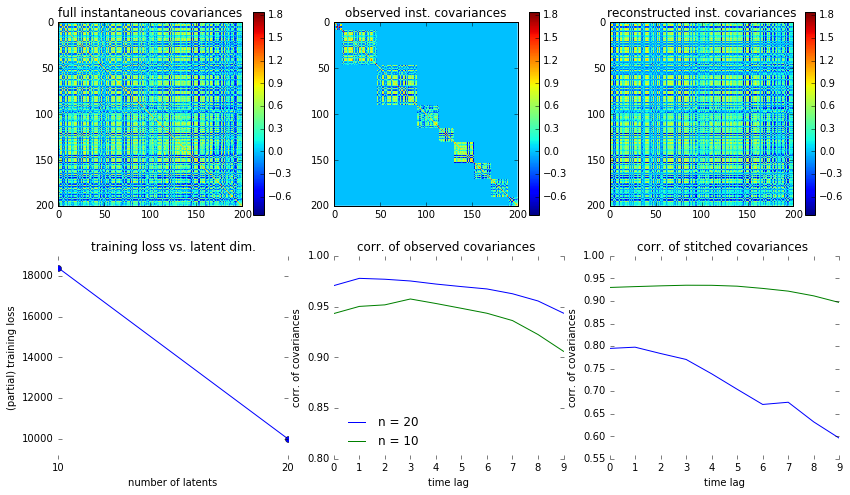

In [25]:
#import seaborn

plt.figure(figsize=(14,8))

# further subsample for displaying purposes!
idx_Q = np.ix_(np.arange(0,len(idx_a),10), np.arange(0,len(idx_b),10))
idx_a = idx_a[::10]
idx_b = idx_b[::10]

clims = [np.min(Qs[0]), np.max(Qs[0])]

plt.subplot(2,3,2)
plt.imshow(Qs[0][idx_Q], interpolation='None')
plt.colorbar()
plt.grid('off')
plt.title('observed inst. covariances')

plt.subplot(2,3,1)
y_ = np.memmap(data_path+'y_' + idx_str + '_zscore', dtype=np.float, mode='r', shape=(T,p))
Qgd = np.cov(y_[np.ix_(np.arange(0, T-kl_), idx_a)].T,
             y_[np.ix_(np.arange(0, T-kl_), idx_a)].T)[:len(idx_a),len(idx_b):]
del y_
clims = [np.minimum(clims[0], np.min(Qgd)), np.maximum(clims[1], np.max(Qgd))]
plt.imshow(Qgd, interpolation='None')
plt.colorbar()
del Qgd
plt.grid('off')
plt.title('full instantaneous covariances')

plt.subplot(2,3,3)
n, m = 10, 0
pars_est =  np.load(data_path + 'p160495n' + str(n) + 'T1200_10sp.npz')['arr_0'].tolist()['pars_est']
for i in range(0,len(obs_scheme.sub_pops),2):
    pars_est['C'][obs_scheme.sub_pops[i],:] *=-1
for m in range(1,len(lag_range),2):
    pars_est['X'][m*n:(m+1)*n,:] *= -1 
Qest = pars_est['C'][idx_a,:].dot(pars_est['X'][:n,:]).dot(pars_est['C'][idx_b,:].T)
#del pars_est
plt.imshow(Qest, interpolation='None')
plt.colorbar()
clims = [np.minimum(clims[0], np.min(Qest)), np.maximum(clims[1], np.max(Qest))]
del Qest
plt.grid('off')
plt.title('reconstructed inst. covariances')

plt.subplot(2,3,1)
plt.clim(clims[0], clims[1])
plt.subplot(2,3,2)
plt.clim(clims[0], clims[1])
plt.subplot(2,3,3)
plt.clim(clims[0], clims[1])

plt.subplot(2,3,4)
plt.plot(ns, loss, 'o-')
plt.ylabel('(partial) training loss')
plt.xlabel('number of latents')
plt.box('off')
plt.title('training loss vs. latent dim.')
plt.xticks(ns)

plt.subplot(2,3,5)
plt.plot(obs_corrs.T)
plt.xlabel('time lag')
plt.ylabel('corr. of covariances')
plt.legend(['n = ' + str(n) for n in ns], loc=3, frameon=False)
plt.box('off')
plt.axis([0,np.max(lag_range), 0.8, 1.])
plt.title('corr. of observed covariances ')

plt.subplot(2,3,6)
plt.plot(stc_corrs.T)
plt.xlabel('time lag')
plt.ylabel('corr. of covariances')
#plt.legend(['n = ' + str(n) for n in ns], loc=3, frameon=False)
plt.box('off')
plt.axis([0,np.max(lag_range), .55, 1.])
plt.title('corr. of stitched covariances ')
plt.savefig(data_path + 'res_summary_10subpops_zebrafish_small.pdf')
plt.show()

In [ ]:
from ssidid.SSID_Hankel_loss import f_l2_Hankel_comp_Q_Om
from ssidid import ObservationScheme

data_path = '/media/marcel/636f7b46-1fd1-4600-b69e-86d2ed82002c/stitching/hankel/zebrafish/'
idx_str = 'small'
idx_fish = np.load(data_path + 'idx_' + idx_str + '.npy')
p = len(idx_fish)

"""
nx, ny, nz = 41, 1024, 2048
p_full = nx * ny * nz
tmp = np.arange(p_full)
tmp =tmp.reshape(nx,ny,nz)

ns = 10
sub_pops = [np.where(np.in1d(idx_fish, np.intersect1d(tmp[i*nx//ns:(i+1)*nx//ns,:,:].reshape(-1), idx_fish)))[0] for i in range(ns-1)]
sub_pops.append(np.where(np.in1d(idx_fish, np.intersect1d(tmp[(ns-1)*nx//ns:,:,:].reshape(-1), idx_fish)))[0])

reps = 60
obs_pops = np.concatenate([ np.arange(len(sub_pops)) for r in range(reps) ])
obs_time = np.linspace(0,T, len(obs_pops)+1)[1:].astype(int)
obs_scheme = ObservationScheme(p=p, T=T, 
                                sub_pops=sub_pops, 
                                obs_pops=obs_pops, 
                                obs_time=obs_time)
obs_scheme.comp_subpop_stats()

tmp = np.round([2000/p * len(sub_pops[i]) for i in range(len(sub_pops))]).astype(np.int)
idx_a = np.hstack([np.sort(np.random.choice(sub_pops[i], tmp[i], replace=False)) for i in range(len(sub_pops))])
idx_b = idx_a.copy()
del tmp


y = np.memmap(data_path+'y', dtype=np.float, mode='r', shape=(T,p))


W = obs_scheme.comp_coocurrence_weights(lag_range, sso=True, idx_a=idx_a, idx_b=idx_b)
Qs, Om = f_l2_Hankel_comp_Q_Om(n=n,y=y,lag_range=lag_range,obs_scheme=obs_scheme,
                      idx_a=idx_a,idx_b=idx_b,W=W,
                      mmap=mmap,data_path=data_path,ts=None,ms=None)

plt.figure(figsize=(3*kl_,3))
plt.imshow(np.hstack([1./W[m] for m in range(len(lag_range))]), aspect='auto', interpolation='None')
plt.colorbar()
plt.show()

"""
sub_pops = obs_scheme.sub_pops

m = 0
y_ = np.memmap(data_path+'y_' + idx_str + '_zscore', dtype=np.float, mode='r', shape=(T,p))
ya = y_[m:-kl_+m, idx_a].copy()
yb = y_[:-kl_, idx_b].copy()
del y_

Qgd = np.cov(ya.T, yb.T)[:len(idx_a), len(idx_b):]
del ya
del yb    
Qest = pars_est['C'][idx_a,:].dot(pars_est['X'][m*n:(m+1)*n,:]).dot(pars_est['C'][idx_b,:].T)

corrcoeffs = np.zeros((len(sub_pops), len(sub_pops)))
for i in range(len(sub_pops)):
    idx_ai = np.where( np.in1d(idx_a, sub_pops[i]) )[0]
    for j in range(len(sub_pops)):
        idx_bi = np.where( np.in1d(idx_b, sub_pops[j]) )[0]
        corrcoeffs[i,j] = np.corrcoef(Qest[np.ix_(idx_ai, idx_bi)].reshape(-1), Qgd[np.ix_(idx_ai, idx_bi)].reshape(-1))[0,1]

plt.figure(figsize=(16,8))
plt.subplot(1,2,2)
plt.imshow(corrcoeffs, interpolation='None')
plt.title('pairwise subpopulation correlations ')
plt.colorbar()
plt.subplot(1,2,1)
idx_plot = np.random.choice(np.invert(Om[0]).sum(), 10000, replace=False)
plt.plot(Qgd[np.invert(Om[m])][idx_plot],Qest[np.invert(Om[m])][idx_plot], '.')
plt.title('stitched covariances')
#plt.savefig(data_path + 'sign_flips_n2.pdf')
plt.show()

In [ ]:
W = obs_scheme.comp_coocurrence_weights(lag_range, sso=True, idx_a=idx_a, idx_b=idx_b)

plt.figure(figsize=(2*kl_,5))
obs_scheme.gen_mask_from_scheme()
plt.subplot(2,1,1)
plt.imshow(obs_scheme.mask[:100,1:-1:100].T, aspect='auto', interpolation='None')
plt.grid('off')
plt.title('observation scheme')

plt.subplot(2,1,2)
plt.imshow(np.hstack([1./W[m] for m in range(len(lag_range))]), aspect='auto', interpolation='None')
plt.colorbar()
plt.xticks(np.arange(0,kl_*len(obs_scheme.idx_grp), 10))
plt.hold(True)
#for i in range(kl_):
#    plt.plot([i*len(obs_scheme.idx_grp), i*len(obs_scheme.idx_grp)], [9, len(obs_scheme.idx_grp)], color='w')
plt.hold(False)
plt.title('subpop co-observation counts [bins]')
plt.savefig(data_path + '10subpops_no_overlap_obs_scheme.pdf')
plt.show()

# 2 overlapping subpopulations (z-planes 1:21 & 21:41)

In [ ]:
% matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import glob, os, psutil, time

from ssidid.SSID_Hankel_loss import run_bad, plot_slim, print_slim, f_l2_Hankel_nl
from ssidid.utility import get_subpop_stats, gen_data
from ssidid import ObservationScheme
from subtracking import Grouse, calc_subspace_proj_error

run = '_overlap_stitch'
ns = (5, 10, 50)

data_path = '../fits/lsfm/grid_quick/'
idx_str = 'small'
idx_fish = np.load(data_path + 'idx_' + idx_str + '.npy')

T, p = 1200, len(idx_fish)
lag_range = np.arange(0,10)
kl_ = np.max(lag_range)+1
snr = (0., 0.)
verbose=True

def get_corrs(Qs,Om,lag_range,pars,idx_a,idx_b,traces,mmap):
    kl = len(lag_range)
    p,n = pars['C'].shape
    pa, pb = idx_a.size, idx_b.size
    idx_ab = np.intersect1d(idx_a, idx_b)
    idx_a_ab = np.where(np.in1d(idx_a, idx_ab))[0]
    idx_b_ab = np.where(np.in1d(idx_b, idx_ab))[0]
    out = np.zeros(len(lag_range))
    for m in range(kl): 
        m_ = lag_range[m] 
        Qrec = pars['C'][idx_a,:].dot(pars['X'][m*n:(m+1)*n, :]).dot(pars['C'][idx_b,:].T) 
        if m_ == 0:
            Qrec[np.ix_(idx_a_ab, idx_b_ab)] += np.diag(pars['R'][idx_ab])
        if mmap:
            Q = np.memmap(data_path+'Qs_'+str(m_), dtype=np.float, mode='r', shape=(pa,pb))
        else:
            Q = Qs[m]
        out[m] = np.corrcoef( Qrec[Om[m]].reshape(-1), (Qs[m][Om[m]]).reshape(-1) )[0,1]
        if mmap:
            del Q
    return out

obs_corrs = np.zeros((len(ns), len(lag_range)))
stc_corrs = np.zeros((len(ns), len(lag_range)))
loss      = np.zeros( len(ns) )
for ni in range(len(ns)):
    
    n = ns[ni]

    file_name = 'p' + str(p) + 'n' + str(n) + 'T' + str(T) + 'snr' + str(np.int(np.mean(snr)//1)) + '_run' + str(run)

    load_file = np.load(data_path + file_name + '.npz')['arr_0'].tolist()
    mmap = load_file['mmap']
    y, x, snr, idx_a, idx_b = load_file['y'], load_file['x'], load_file['snr'], load_file['idx_a'], load_file['idx_b'] 
    pars_true, pars_est, obs_scheme = load_file['pars_true'], load_file['pars_est'],load_file['obs_scheme']
    W, Om= load_file['W'], load_file['Om']
    Qs = [np.load(data_path+'Qs_'+str(lag_range[m])+'.npy') for m in range(len(lag_range)) ]
    W = obs_scheme.comp_coocurrence_weights(lag_range, sso=True, idx_a=idx_a, idx_b=idx_b) if W is None else W

    y = np.memmap(data_path+'y', dtype=np.float, mode='r', shape=(T,p))

    print('(T,p,n)', (T,p,n))

    #print_slim(Qs,Om,lag_range,pars_est,idx_a,idx_b,_,False,data_path)
    obs_corrs[ni,:] = get_corrs(Qs,Om,lag_range,pars_est,idx_a,idx_b,None,False)
    loss[ni] = f_l2_Hankel_nl(C=pars_est['C'],
                                   X=pars_est['X'],
                                   R=pars_est['R'],
                                   Qs=Qs,
                                   Om=Om,
                                   lag_range=lag_range,
                                   ms=range(len(lag_range)),
                                   idx_a=idx_a,
                                   idx_b=idx_b)
    

    for m in lag_range:    
        y_ = np.memmap(data_path+'y_' + idx_str + '_zscore', dtype=np.float, mode='r', shape=(T,p))
        ya = y_[m:-kl_+m, idx_a].copy()
        yb = y_[:-kl_, idx_b].copy()
        del y_

        Qgd = np.cov(ya.T, yb.T)[:len(idx_a), len(idx_b):]
        del ya
        del yb    
        Qest = pars_est['C'][idx_a,:].dot(pars_est['X'][m*n:(m+1)*n,:]).dot(pars_est['C'][idx_b,:].T)

        # notice that we take Om[0] for all m below: Om[1] etc. is 'fully observed' because it's only two subpops
        # and we keep switching a couple of times. Actually however, this is something one would not take
        # into account when fitting systems individually, so we reduce to inst. co-observations, i.e. Om[0]
        stc_corrs[ni,m] = np.corrcoef(Qgd[np.invert(Om[0])], Qest[np.invert(Om[0])])[0,1]
        del Qest
        del Qgd


In [ ]:
#import seaborn

plt.figure(figsize=(14,8))

clims = [np.min(Qs[0]), np.max(Qs[0])]

plt.subplot(2,3,1)
plt.imshow(Qs[0], interpolation='None')
plt.colorbar()
plt.grid('off')
plt.title('observed inst. covariances')

plt.subplot(2,3,2)
y_ = np.memmap(data_path+'y_' + idx_str + '_zscore', dtype=np.float, mode='r', shape=(T,p))
ya = y_[:-kl_, idx_a].copy()
yb = y_[:-kl_, idx_b].copy()
del y_
Qgd = np.cov(ya.T, yb.T)[:len(idx_a), len(idx_b):]
clims = [np.minimum(clims[0], np.min(Qgd)), np.maximum(clims[1], np.max(Qgd))]
del ya
del yb       
plt.imshow(Qgd, interpolation='None')
plt.colorbar()
del Qgd
plt.grid('off')
plt.title('full instantaneous covariances')

plt.subplot(2,3,3)
n, m = 10, 0
pars_est =  np.load(data_path + 'p160495n' + str(n) + 'T1200snr0_run_real_stitch.npz')['arr_0'].tolist()['pars_est']
Qest = pars_est['C'][idx_a,:].dot(pars_est['X'][m*n:(m+1)*n,:]).dot(pars_est['C'][idx_b,:].T)
del pars_est
plt.imshow(Qest, interpolation='None')
plt.colorbar()
clims = [np.minimum(clims[0], np.min(Qest)), np.maximum(clims[1], np.max(Qest))]
del Qest
plt.grid('off')
plt.title('reconstructed inst. covariances')

plt.subplot(2,3,1)
plt.clim(clims[0], clims[1])
plt.subplot(2,3,2)
plt.clim(clims[0], clims[1])
plt.subplot(2,3,3)
plt.clim(clims[0], clims[1])

plt.subplot(2,3,4)
plt.plot(ns, loss, 'o-')
plt.ylabel('(partial) training loss')
plt.xlabel('time lag')
plt.box('off')
plt.title('training loss vs. latent dim.')
plt.xticks(ns)

plt.subplot(2,3,5)
plt.plot(obs_corrs.T)
plt.xlabel('time lag')
plt.ylabel('corr. of covariances')
plt.legend(['n = ' + str(n) for n in ns], loc=3, frameon=False)
plt.box('off')
plt.axis([0,np.max(lag_range), 0.75, 1.])
plt.title('corr. of observed covariances ')

plt.subplot(2,3,6)
plt.plot(stc_corrs.T)
plt.xlabel('time lag')
plt.ylabel('corr. of covariances')
#plt.legend(['n = ' + str(n) for n in ns], loc=3, frameon=False)
plt.box('off')
plt.axis([0,np.max(lag_range), 0.75, 1.])
plt.title('corr. of stitched covariances ')
plt.savefig(data_path + 'res_summary_2subpops_zebrafish_small.pdf')
plt.show()

In [ ]:
from ssidid.SSID_Hankel_loss import f_l2_Hankel_comp_Q_Om
data_path = '../fits/lsfm/grid_quick/'
pars_true,x=None,None

y_ = np.memmap(data_path+'y_' + idx_str + '_zscore', dtype=np.float, mode='r', shape=(T,p))
y = np.memmap(data_path+'y', dtype=np.float, mode='w+', shape=(T,p))
y[:] = y_.copy()
del y_

for i in range(len(obs_scheme.idx_grp)):
    m = y[np.ix_(obs_scheme.idx_time[i], obs_scheme.idx_grp[i])].mean(axis=0)
    assert len(m)==len(obs_scheme.idx_grp[i])
    y[np.ix_(obs_scheme.idx_time[i], obs_scheme.idx_grp[i])] -= m.reshape(1, len(obs_scheme.idx_grp[i]))
    plt.plot(m, 'g')
    plt.hold(True)
    plt.plot(y[np.ix_(obs_scheme.idx_time[i], obs_scheme.idx_grp[i])].mean(axis=0), 'b')
    plt.show()
del y
y = np.memmap(data_path+'y', dtype=np.float, mode='r', shape=(T,p))

#idx_a = np.sort(np.random.choice(p,2000,replace=False)) if p > 2000 else np.arange(p)
#idx_b = idx_a.copy() #np.sort(np.random.choice(p,1000,replace=False)) if p > 1000 else np.arange(p)

W = obs_scheme.comp_coocurrence_weights(lag_range, sso=True, idx_a=idx_a, idx_b=idx_b)
Qs, Om = f_l2_Hankel_comp_Q_Om(n=n,y=y,lag_range=lag_range,obs_scheme=obs_scheme,
                      idx_a=idx_a,idx_b=idx_b,W=W,
                      mmap=mmap,data_path=data_path,ts=None,ms=None)

plt.figure(figsize=(3*kl_,3))
plt.imshow(np.hstack([1./W[m] for m in range(len(lag_range))]), aspect='auto', interpolation='None')
plt.colorbar()
plt.show()